In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
sys.path.append("../..")

from xlstm_scaling_laws.analysis.fit_inference_time_model.objective_funcs import (
    InferenceModelObjectiveConfig,
    get_inference_time_model_objective_func,
)
from xlstm_scaling_laws.load_data.inference_time import load_inference_time_data
from xlstm_scaling_laws.fitting.common.run_fit import run_optimization, OptimizationConfig
from xlstm_scaling_laws.fitting.common.initialization import generate_initialization_sweep
from xlstm_scaling_laws.model_accounting.inference_time_model.llama_runtime_model import (
    predict_runtime_llama_ttft,
)
import matplotlib.pyplot as plt
import seaborn as sns

# Llama: Fit the data of one model size and one batch size



In [2]:
ttft_df, step_time_df = load_inference_time_data("llama2")

In [3]:
ttft_df["model", "model_tag"].unique()

array(['llama2_160m', 'llama2_400m', 'llama2_830m', 'llama2_1.4b',
       'llama2_2.7b', 'llama2_7b'], dtype=object)

In [4]:
model = "llama2_7b"
df = ttft_df.dropna()
df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model]#[df[("input_params", "batchsize")] == 8]
data_df = df.copy()

/tmp/ipykernel_195527/3643252926.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model]#[df[("input_params", "batchsize")] == 8]


In [5]:
data_df

model            input_params         measured_data  \
    model_type  model_tag    batchsize prefill    num_params   
651     llama2  llama2_7b            1     128    6863196160   
652     llama2  llama2_7b            1     256    6863196160   
653     llama2  llama2_7b            1     512    6863196160   
654     llama2  llama2_7b            1    1024    6863196160   
655     llama2  llama2_7b            1    2048    6863196160   
656     llama2  llama2_7b            1    4096    6863196160   
657     llama2  llama2_7b            1    8192    6863196160   
658     llama2  llama2_7b            1   12288    6863196160   
659     llama2  llama2_7b            1   16384    6863196160   
661     llama2  llama2_7b            2     128    6863196160   
662     llama2  llama2_7b            2     256    6863196160   
663     llama2  llama2_7b            2     512    6863196160   
664     llama2  llama2_7b            2    1024    6863196160   
665     llama2  llama2_7b            2    2048    6863196160   
666     llama2  llama2_7b            2    4096    6863196160   
667     llama2  llama2_7b            2    8192    6863196160   
668     llama2  llama2_7b            2   12288    6863196160   
669     llama2  llama2_7b            2   16384    6863196160   
671     llama2  llama2_7b            4     128    6863196160   
672     llama2  llama2_7b            4     256    6863196160   
673     llama2  llama2_7b            4     512    6863196160   
674     llama2  llama2_7b            4    1024    6863196160   
675     llama2  llama2_7b            4    2048    6863196160   
676     llama2  llama2_7b            4    4096    6863196160   
677     llama2  llama2_7b            4    8192    6863196160   
678     llama2  llama2_7b            4   12288    6863196160   
679     llama2  llama2_7b            4   16384    6863196160   
681     llama2  llama2_7b            8     128    6863196160   
682     llama2  llama2_7b            8     256    6863196160   
683     llama2  llama2_7b            8     512    6863196160   
684     llama2  llama2_7b            8    1024    6863196160   
685     llama2  llama2_7b            8    2048    6863196160   
686     llama2  llama2_7b            8    4096    6863196160   
687     llama2  llama2_7b            8    8192    6863196160   
691     llama2  llama2_7b           16     128    6863196160   
692     llama2  llama2_7b           16     256    6863196160   
693     llama2  llama2_7b           16     512    6863196160   
694     llama2  llama2_7b           16    1024    6863196160   
695     llama2  llama2_7b           16    2048    6863196160   
696     llama2  llama2_7b           16    4096    6863196160   
701     llama2  llama2_7b           32     128    6863196160   
702     llama2  llama2_7b           32     256    6863196160   
703     llama2  llama2_7b           32     512    6863196160   
704     llama2  llama2_7b           32    1024    6863196160   
705     llama2  llama2_7b           32    2048    6863196160   
711     llama2  llama2_7b           64     128    6863196160   
712     llama2  llama2_7b           64     256    6863196160   
713     llama2  llama2_7b           64     512    6863196160   
714     llama2  llama2_7b           64    1024    6863196160   
721     llama2  llama2_7b          128     128    6863196160   
722     llama2  llama2_7b          128     256    6863196160   
723     llama2  llama2_7b          128     512    6863196160   
731     llama2  llama2_7b          256     128    6863196160   
732     llama2  llama2_7b          256     256    6863196160   
741     llama2  llama2_7b          384     128    6863196160   
751     llama2  llama2_7b          512     128    6863196160   
761     llama2  llama2_7b          768     128    6863196160   

                                                                     \
    memory_allocated_gl1 memory_reserved_gl1 memory_allocated_gl101   
651          14135503360         14237564928            15108581888   
652          141690

## Plot the raw data

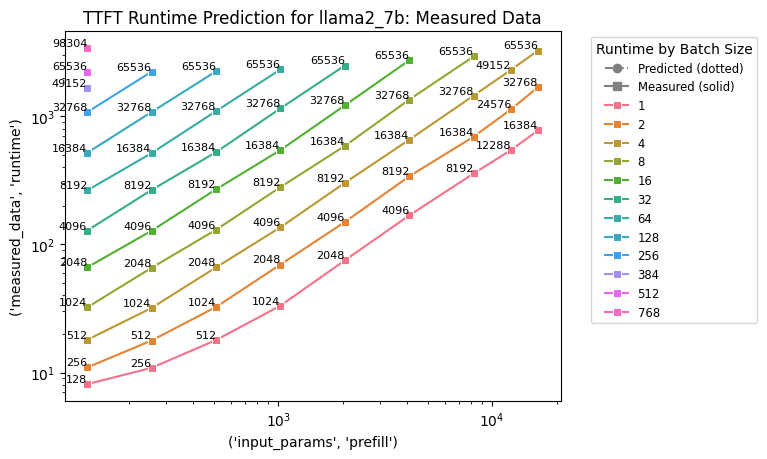

In [6]:
df = data_df.copy()
# bs = 8
# df = df[df[("input_params", "batchsize")] == bs]

df = df[df[("model", "model_tag")] == model][df[("input_params", "batchsize")] < 2000]
df[("input_params", "batchsize")] = df[("input_params", "batchsize")].astype(str)
# df[("pred", "runtime")] = df[("pred", "runtime")]
# # ax = sns.lineplot(df, x=("input_params", "prefill"), y=('predicted_data', 'pred'), hue=("model", "model_tag"), markers=True, dashes=False)
# ax = sns.lineplot(
#     df,
#     x=("input_params", "prefill"),
#     y=("pred", "runtime"),
#     hue=("input_params", "batchsize"),
#     markers=True,
#     dashes=False,
#     marker="o",
#     linestyle="--",
#     alpha=0.5,
#     legend=False,
# )
ax = sns.lineplot(
    df,
    x=("input_params", "prefill"),
    y=("measured_data", "runtime"),
    hue=("input_params", "batchsize"),
    markers=True,
    dashes=False,
    marker="s",
    legend="auto",
)
# # ax = sns.lineplot(df, x=("input_params", "prefill"), y=('measured_data', 'runtime'), hue=('measured_data', 'num_params'), markers=True, dashes=False)
# Custom legend handles
import matplotlib.lines as mlines

dotted_line = mlines.Line2D(
    [], [], color="gray", linestyle="--", marker="o", label="Predicted (dotted)"
)
solid_line = mlines.Line2D(
    [], [], color="gray", linestyle="-", marker="s", label="Measured (solid)"
)
# header

# for each measured dot, calculate batchsize * prefill and add as text label
for line in ax.lines:
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    for x, y in zip(x_data, y_data):
        # find the corresponding batchsize
        batchsize = df[
            (df[("input_params", "prefill")] == x)
            & (df[("measured_data", "runtime")] == y)
        ][("input_params", "batchsize")].values[0]

        ax.text(
            x,
            y,
            f"{int(batchsize) * int(x)}",
            fontsize=8,
            verticalalignment="bottom",
            horizontalalignment="right",
        )

# Existing legend handles (for batchsize)
handles, labels = ax.get_legend_handles_labels()

# Combine custom and existing handles
custom_handles = [dotted_line, solid_line]
ax.legend(
    custom_handles + handles,
    ["Predicted (dotted)", "Measured (solid)"] + labels,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title="Runtime by Batch Size",
    fontsize="small",
)

# param_str = ", ".join([f"{k}={v:.2e}" for k, v in opt_params.items()])
param_str = "Measured Data"
ax.set_title(f"TTFT Runtime Prediction for {model}: {param_str}")
ax.set_yscale("log")
# ax.set_ylim(0, 500)
ax.set_xscale("log")

## Fit the model

In [7]:
df = ttft_df.dropna()
df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model]#[df[("input_params", "batchsize")] <= 8]
data_df = df.copy()
optim_cfg = OptimizationConfig(
    objective_func_config=InferenceModelObjectiveConfig(
        huber_delta=0,
        filter_zero_prefill=True,
        fit_data="ttft",
        fit_model="llama2",
        runtime_model_mode="log_linear_flops", #"attainable_flops_logsumexp", #"linear_sum_flops_memops", #"linear_flops",
        factor_causal=0.6,
        bytes_act=2,
        bytes_Cmn=4,
        bytes_w=2,
        override_df=data_df,
        reduce_loss="none",
        squeeze_loos=True,
    ),
    scipy_optim_module="least_squares",
    method="lm",
    bootstrap_seed=0,
    num_bootstrap_samples=-1,
    # initialization_grid={
    #     "alpha": [900e12],
    #     "beta": [3.35e13],
    #     "rho": [1e-14],
    # },
    initialization_grid={
        "alpha": [0.39 * 900e12],
        # "beta": [0.5 * 282e10],
        # "rho": [1e-2],
        "eps": [1e-3],
        "eps_bp": [1e-5] 
    },
    tol=1e-15,
    other_optimization_kwargs=dict(
        # xtol=1e-15,
        # gtol=1e-15,
        # ftol=1e-14,
    )
)
print(optim_cfg.initialization_grid)

{'alpha': [351000000000000.0], 'eps': [0.001], 'eps_bp': [1e-05]}


/tmp/ipykernel_195527/1002072553.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model]#[df[("input_params", "batchsize")] <= 8]


In [8]:
len(data_df)

57

In [9]:
optim_res_df = run_optimization(
    config=optim_cfg,
    objective_func_generator=get_inference_time_model_objective_func,
)

Running optimization: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


In [10]:
optim_res_df.T

0
idxes         init_idx                                                       0
              bootstrap_idx                                                  0
optim_params  alpha                                          392512810798001.5
              eps                                                     0.003229
              eps_bp                                                   0.00001
optim_results loss           [0.04270334259448472, 0.030013823233455916, 0....
              message               `xtol` termination condition is satisfied.
              success                                                     True
              jac            [[2.543989761388041e-15, -0.4494464438647384, ...
              nfev                                                          25
              njev                                                        None
              status                                                         3
init_params   alpha                                          351000000000000.0
              eps                                                        0.001
              eps_bp                                                   0.00001

In [11]:
opt_params = optim_res_df.iloc[0, :]["optim_params"].to_dict()
# if optim_cfg.objective_func_config.runtime_model_mode.startswith("log_"):
#     opt_params = {k: float(np.exp(v)) for k, v in opt_params.items()}
print(opt_params)

{'alpha': 392512810798001.5, 'eps': 0.003229368329080882, 'eps_bp': 1e-05}


In [12]:
# opt_params = {
#     # "alpha": 0.39 * 900e12,
#     "beta": 0.4 * 282e12,
#     # ""rho": 1e-14,
#     "eps": 0.0014,
#     "eps_bp": 0
# }
# opt_params
# opt_params["eps"] = 2e-3

In [13]:
# careful if you get a typerror here it is because we converted batch size to string in the next cell u
# and you rerun this cell
# so the batch size is not a number anymore
# pred_ttft_df = predict_runtime_mlstm_ttft(
#     ttft_df=df.iloc[:, :],
#     **{'alpha': 900e12, 'beta': 3.35e13, 'rho': 1e-14},
#     mode="attainable_flops_min", #"attainable_flops_logsumexp",
# )
pred_ttft_df = predict_runtime_llama_ttft(
    ttft_df=data_df.iloc[:, :],
    **opt_params,
    mode="linear_flops", #"attainable_flops_logsumexp", #"linear_sum_flops_memops", #"linear_flops", #"linear_memops"
)

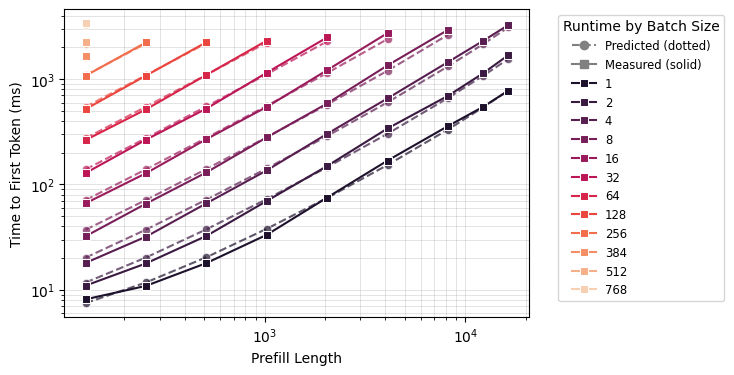

In [14]:
df = pred_ttft_df.copy()
# bs = 8
# df = df[df[("input_params", "batchsize")] == bs]

df = df[df[("model", "model_tag")] == model][df[("input_params", "batchsize")] < 2000]
df[("input_params", "batchsize")] = df[("input_params", "batchsize")].astype(str)
df[("pred", "runtime")] = df[("pred", "runtime")]
# ax = sns.lineplot(df, x=("input_params", "prefill"), y=('predicted_data', 'pred'), hue=("model", "model_tag"), markers=True, dashes=False)
plt.figure(figsize=(6, 4))
ax = sns.lineplot(
    df,
    x=("input_params", "prefill"),
    y=("pred", "runtime"),
    hue=("input_params", "batchsize"),
    markers=True,
    dashes=False,
    marker="o",
    linestyle="--",
    alpha=0.7,
    palette="rocket",
    legend=False,
)
ax = sns.lineplot(
    df,
    x=("input_params", "prefill"),
    y=("measured_data", "runtime"),
    hue=("input_params", "batchsize"),
    markers=True,
    dashes=False,
    marker="s",
    legend="auto",
    palette="rocket",
)
ax.set_ylabel("Time to First Token (ms)")
ax.set_xlabel("Prefill Length")
# # ax = sns.lineplot(df, x=("input_params", "prefill"), y=('measured_data', 'runtime'), hue=('measured_data', 'num_params'), markers=True, dashes=False)
# Custom legend handles
import matplotlib.lines as mlines

dotted_line = mlines.Line2D(
    [], [], color="gray", linestyle="--", marker="o", label="Predicted (dotted)"
)
solid_line = mlines.Line2D(
    [], [], color="gray", linestyle="-", marker="s", label="Measured (solid)"
)
# header

# Existing legend handles (for batchsize)
handles, labels = ax.get_legend_handles_labels()

# Combine custom and existing handles
custom_handles = [dotted_line, solid_line]
ax.legend(
    custom_handles + handles,
    ["Predicted (dotted)", "Measured (solid)"] + labels,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title="Runtime by Batch Size",
    fontsize="small",
)

# param_str = ", ".join([f"{k}={v:.2e}" for k, v in opt_params.items()])
# ax.set_title(f"TTFT Runtime Prediction for {model}: {param_str}")
ax.grid(True, which="both", ls="-", lw=0.5, alpha=0.5)
ax.set_yscale("log")
ax.set_xscale("log")
# save figure
plt.savefig(os.path.join("plots", f"ttft_runtime_prediction_llama.pdf"), bbox_inches="tight", dpi=300)

In [15]:
pred_ttft_df[["input_params", "pred"]].head(50)

input_params                 pred                                     \
       batchsize prefill      runtime arithmetic_intensity    flops_algo   
651            1     128     7.469056           117.692591  1.664132e+12   
652            1     256    11.736422           223.883958  3.339128e+12   
653            1     512    20.357336           408.333793  6.722947e+12   
654            1    1024    37.943897           696.480507  1.362590e+13   
655            1    2048    74.495945          1085.778879  2.797304e+13   
656            1    4096   153.115747          1541.667939  5.883232e+13   
657            1    8192   332.418180          2052.327153  1.292108e+14   
658            1   12288   541.137716          2405.972249  2.111359e+14   
659            1   16384   779.274356          2706.380539  3.046076e+14   
661            2     128    11.708744           223.153799  3.328264e+12   
662            2     256    20.243476           405.616452  6.678255e+12   
663            2     512    37.485305           687.275619  1.344589e+13   
664            2    1024    72.658426          1057.778632  2.725179e+13   
665            2    2048   145.762521          1466.031270  5.594609e+13   
666            2    4096   303.002126          1868.929337  1.176646e+14   
667            2    8192   661.606991          2296.024794  2.584217e+14   
668            2   12288  1079.046064          2604.281751  4.222718e+14   
669            2   16384  1555.319344          2877.203301  6.092152e+14   
671            4     128    20.188120           404.291030  6.656527e+12   
672            4     256    37.257583           682.698689  1.335651e+13   
673            4     512    71.741241          1043.795487  2.689179e+13   
674            4    1024   142.087483          1428.222739  5.450359e+13   
675            4    2048   288.295674          1777.235548  1.118922e+14   
676            4    4096   602.774883          2090.849473  2.353293e+14   
677            4    8192  1319.984614          2440.946344  5.168433e+14   
678            4   12288  2154.862759          2716.222513  8.445437e+14   
679            4   16384  3107.409320          2970.964765  1.218430e+15   
681            8     128    37.146872           680.461247  1.331305e+13   
682            8     256    71.285798          1036.837870  2.671302e+13   
683            8     512   140.253113          1409.338081  5.378358e+13   
684            8    1024   280.945597          1731.398894  1.090072e+14   
685            8    2048   573.361979          1988.266917  2.237844e+14   
686            8    4096  1202.320398          2222.820381  4.706586e+14   
687            8    8192  2636.739859          2520.491103  1.033687e+15   
691           16     128    71.064376          1033.426968  2.662611e+13   
692           16     256   139.342228          1399.934965  5.342604e+13   
693           16     512   277.276858          1708.501045  1.075672e+14   
694           16    1024   558.661826          1936.985846  2.180144e+14   
695           16    2048  1143.494590          2113.762431  4.475687e+14   
696           16    4096  2401.411428          2295.256758  9.413172e+14   
701           32     128   138.899384          1395.311828  5.325222e+13   
702           32     256   275.455087          1697.093077  1.068521e+14   
703           32     512   551.324348          1911.365725  2.151343e+14   
704           32    1024  1114.094284          2059.243519  4.360287e+14   
705           32    2048  2283.759811          2182.644557  8.951374e+14   
711           64     128   274.569399          1691.470996  1.065044e+14   
712           64     256   547.680806          1898.596491  2.137042e+14   
713           64     512  1099.419328          2032.004187  4.302686e+14   
714           64    1024  2224.959200          2126.348399  8.720574e+14   
721          128     128   545.909430          1892.293516  2.130089e+14   

                   
      memops_algo  
651  1.4139

In [16]:
data_df

model            input_params         measured_data  \
    model_type  model_tag    batchsize prefill    num_params   
651     llama2  llama2_7b            1     128    6863196160   
652     llama2  llama2_7b            1     256    6863196160   
653     llama2  llama2_7b            1     512    6863196160   
654     llama2  llama2_7b            1    1024    6863196160   
655     llama2  llama2_7b            1    2048    6863196160   
656     llama2  llama2_7b            1    4096    6863196160   
657     llama2  llama2_7b            1    8192    6863196160   
658     llama2  llama2_7b            1   12288    6863196160   
659     llama2  llama2_7b            1   16384    6863196160   
661     llama2  llama2_7b            2     128    6863196160   
662     llama2  llama2_7b            2     256    6863196160   
663     llama2  llama2_7b            2     512    6863196160   
664     llama2  llama2_7b            2    1024    6863196160   
665     llama2  llama2_7b            2    2048    6863196160   
666     llama2  llama2_7b            2    4096    6863196160   
667     llama2  llama2_7b            2    8192    6863196160   
668     llama2  llama2_7b            2   12288    6863196160   
669     llama2  llama2_7b            2   16384    6863196160   
671     llama2  llama2_7b            4     128    6863196160   
672     llama2  llama2_7b            4     256    6863196160   
673     llama2  llama2_7b            4     512    6863196160   
674     llama2  llama2_7b            4    1024    6863196160   
675     llama2  llama2_7b            4    2048    6863196160   
676     llama2  llama2_7b            4    4096    6863196160   
677     llama2  llama2_7b            4    8192    6863196160   
678     llama2  llama2_7b            4   12288    6863196160   
679     llama2  llama2_7b            4   16384    6863196160   
681     llama2  llama2_7b            8     128    6863196160   
682     llama2  llama2_7b            8     256    6863196160   
683     llama2  llama2_7b            8     512    6863196160   
684     llama2  llama2_7b            8    1024    6863196160   
685     llama2  llama2_7b            8    2048    6863196160   
686     llama2  llama2_7b            8    4096    6863196160   
687     llama2  llama2_7b            8    8192    6863196160   
691     llama2  llama2_7b           16     128    6863196160   
692     llama2  llama2_7b           16     256    6863196160   
693     llama2  llama2_7b           16     512    6863196160   
694     llama2  llama2_7b           16    1024    6863196160   
695     llama2  llama2_7b           16    2048    6863196160   
696     llama2  llama2_7b           16    4096    6863196160   
701     llama2  llama2_7b           32     128    6863196160   
702     llama2  llama2_7b           32     256    6863196160   
703     llama2  llama2_7b           32     512    6863196160   
704     llama2  llama2_7b           32    1024    6863196160   
705     llama2  llama2_7b           32    2048    6863196160   
711     llama2  llama2_7b           64     128    6863196160   
712     llama2  llama2_7b           64     256    6863196160   
713     llama2  llama2_7b           64     512    6863196160   
714     llama2  llama2_7b           64    1024    6863196160   
721     llama2  llama2_7b          128     128    6863196160   
722     llama2  llama2_7b          128     256    6863196160   
723     llama2  llama2_7b          128     512    6863196160   
731     llama2  llama2_7b          256     128    6863196160   
732     llama2  llama2_7b          256     256    6863196160   
741     llama2  llama2_7b          384     128    6863196160   
751     llama2  llama2_7b          512     128    6863196160   
761     llama2  llama2_7b          768     128    6863196160   

                                                                     \
    memory_allocated_gl1 memory_reserved_gl1 memory_allocated_gl101   
651          14135503360         14237564928            15108581888   
652          141690

In [17]:
# plot prediction for very long prefill
import pandas as pd
df = data_df.copy()
pdf = df[["model", "input_params", "model_params"]][df[("input_params", "batchsize")] == 1]
ss = pdf.iloc[0, :]

In [18]:
# prefills = [2000, 4000, 8000, 16000, 32e3, 64e3, 128e3] #256e3, 500e3, 1e6, 2e6, 4e6, 8e6, 16e6, 32e6, 64e6, 128e6
prefills = [128, 256, 512, 1024, 2048, 4096, 8192, 16e3]

sss = [ss.copy() for _ in range(len(prefills))]
for i, p in enumerate(prefills):
    sss[i][("input_params", "prefill")] = p
pdf2 = pd.DataFrame(sss)
pdf2

model            input_params          model_params                \
    model_type  model_tag    batchsize  prefill    num_heads embedding_dim   
651     llama2  llama2_7b            1    128.0         32.0        4096.0   
651     llama2  llama2_7b            1    256.0         32.0        4096.0   
651     llama2  llama2_7b            1    512.0         32.0        4096.0   
651     llama2  llama2_7b            1   1024.0         32.0        4096.0   
651     llama2  llama2_7b            1   2048.0         32.0        4096.0   
651     llama2  llama2_7b            1   4096.0         32.0        4096.0   
651     llama2  llama2_7b            1   8192.0         32.0        4096.0   
651     llama2  llama2_7b            1  16000.0         32.0        4096.0   

                                                                                
    num_blocks ffn_proj_factor ffn_round_up_to_multiple_of vocab_size  ffn_dim  
651       32.0          2.6667                       128.0    50304.0  11008.0  
651       32.0          2.6667                       128.0    50304.0  11008.0  
651       32.0          2.6667                       128.0    50304.0  11008.0  
651       32.0          2.6667                       128.0    50304.0  11008.0  
651       32.0          2.6667                       128.0    50304.0  11008.0  
651       32.0          2.6667                       128.0    50304.0  11008.0  
651       32.0          2.6667                       128.0    50304.0  11008.0  
651       32.0          2.6667                       128.0    50304.0  11008.0

In [19]:
pdf

model            input_params         model_params                \
    model_type  model_tag    batchsize prefill    num_heads embedding_dim   
651     llama2  llama2_7b            1     128         32.0        4096.0   
652     llama2  llama2_7b            1     256         32.0        4096.0   
653     llama2  llama2_7b            1     512         32.0        4096.0   
654     llama2  llama2_7b            1    1024         32.0        4096.0   
655     llama2  llama2_7b            1    2048         32.0        4096.0   
656     llama2  llama2_7b            1    4096         32.0        4096.0   
657     llama2  llama2_7b            1    8192         32.0        4096.0   
658     llama2  llama2_7b            1   12288         32.0        4096.0   
659     llama2  llama2_7b            1   16384         32.0        4096.0   

                                                                                
    num_blocks ffn_proj_factor ffn_round_up_to_multiple_of vocab_size  ffn_dim  
651       32.0          2.6667                       128.0    50304.0  11008.0  
652       32.0          2.6667                       128.0    50304.0  11008.0  
653       32.0          2.6667                       128.0    50304.0  11008.0  
654       32.0          2.6667                       128.0    50304.0  11008.0  
655       32.0          2.6667                       128.0    50304.0  11008.0  
656       32.0          2.6667                       128.0    50304.0  11008.0  
657       32.0          2.6667                       128.0    50304.0  11008.0  
658       32.0          2.6667                       128.0    50304.0  11008.0  
659       32.0          2.6667                       128.0    50304.0  11008.0

In [20]:
print(opt_params)

opt_test = opt_params#{"alpha": 0.8 * opt_params["alpha"]}

{'alpha': 392512810798001.5, 'eps': 0.003229368329080882, 'eps_bp': 1e-05}


In [21]:
pred_ttft_df2 = predict_runtime_llama_ttft(
    ttft_df=pdf2.iloc[:, :],
    **opt_test,
    mode="linear_flops",
)

Text(0.5, 1.0, 'TTFT Runtime Prediction for llama2_7b: Measured Data')

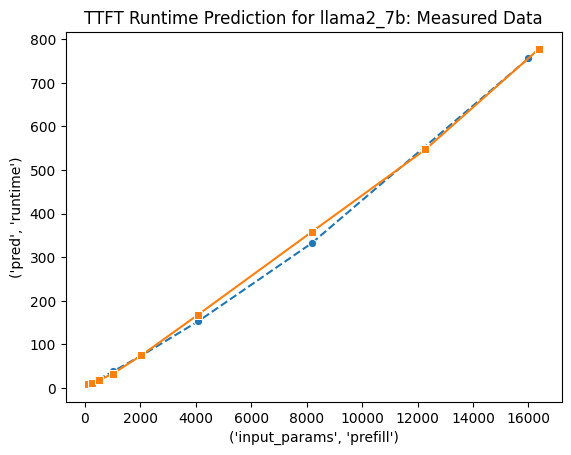

In [22]:
ax = sns.lineplot(
    pred_ttft_df2,
    x=("input_params", "prefill"),
    y=("pred", "runtime"),
    hue=("input_params", "batchsize"),
    markers=True,
    dashes=False,
    marker="o",
    linestyle="--",
    alpha=1.0,
    legend=False,
)
# filter df to contain only batch size 8
df_plot = data_df[data_df[("input_params", "batchsize")] == 1]
ax = sns.lineplot(
    df_plot,
    x=("input_params", "prefill"),
    y=("measured_data", "runtime"),
    markers=True,
    dashes=False,
    marker="s",
    legend="auto",
)
ax.set_title(f"TTFT Runtime Prediction for {model}: {param_str}")
# ax.set_yscale("log")
# ax.set_xscale("log")

In [23]:
alphas = []
for model in ["llama2_160m", "llama2_400m", "llama2_830m", "llama2_1.4b", "llama2_2.7b", "llama2_7b"]:
    df = ttft_df.dropna()
    df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model] #[df[("input_params", "batchsize")] == 8]
    data_df = df.copy()
    optim_cfg = OptimizationConfig(
        objective_func_config=InferenceModelObjectiveConfig(
            huber_delta=1,
            filter_zero_prefill=True,
            fit_data="ttft",
            fit_model="llama2",
            runtime_model_mode="linear_flops", #"linear_sum_flops_memops", #"linear_flops",
            factor_causal=0.6,
            bytes_act=2,
            bytes_Cmn=4,
            bytes_w=2,
            override_df=data_df,
            reduce_loss="none",
            squeeze_loos=True,  # Squeeze the loss to avoid issues with broadcasting
        ),
        scipy_optim_module="least_squares",
        method="lm",
        bootstrap_seed=0,
        num_bootstrap_samples=-1,
        # initialization_grid={
        #     "alpha": [900e12],
        #     "beta": [3.35e13],
        #     "rho": [1e-14],
        # },
        initialization_grid={
            "alpha": [0.39 * 900e12],
            # "beta": [0.5 * 282e10],
            # "rho": [1e-2],
            "eps": [1e-3],
            "eps_bp": [1e-5] 
        },
        tol=1e-15,
        other_optimization_kwargs=dict(
            xtol=1e-15,
            gtol=1e-15,
            # ftol=1e-14,
        )
    )
    print(optim_cfg.initialization_grid)

    optim_res_df = run_optimization(
        config=optim_cfg,
        objective_func_generator=get_inference_time_model_objective_func,
    )
    opt_params = optim_res_df.iloc[0, :]["optim_params"].to_dict()
    if optim_cfg.objective_func_config.runtime_model_mode.startswith("log_"):
        opt_params = {k: float(np.exp(v)) for k, v in opt_params.items()}
    print(opt_params)
    
    alphas.append((model, opt_params["alpha"]))

/tmp/ipykernel_195527/2962871000.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model] #[df[("input_params", "batchsize")] == 8]


{'alpha': [351000000000000.0], 'eps': [0.001], 'eps_bp': [1e-05]}


Running optimization: 100%|██████████| 1/1 [00:10<00:00, 10.64s/it]
/tmp/ipykernel_195527/2962871000.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model] #[df[("input_params", "batchsize")] == 8]


{'alpha': 200141552250592.44, 'eps': -0.000695522197042947, 'eps_bp': 1e-05}
{'alpha': [351000000000000.0], 'eps': [0.001], 'eps_bp': [1e-05]}


Running optimization: 100%|██████████| 1/1 [00:06<00:00,  6.44s/it]
/tmp/ipykernel_195527/2962871000.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model] #[df[("input_params", "batchsize")] == 8]


{'alpha': 245574993758233.78, 'eps': 0.006395630287950451, 'eps_bp': 1e-05}
{'alpha': [351000000000000.0], 'eps': [0.001], 'eps_bp': [1e-05]}


Running optimization: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]
/tmp/ipykernel_195527/2962871000.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model] #[df[("input_params", "batchsize")] == 8]


{'alpha': 271859606167469.84, 'eps': -0.008277612804983176, 'eps_bp': 1e-05}
{'alpha': [351000000000000.0], 'eps': [0.001], 'eps_bp': [1e-05]}


Running optimization: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]
/tmp/ipykernel_195527/2962871000.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model] #[df[("input_params", "batchsize")] == 8]


{'alpha': 334525885874112.25, 'eps': -0.0037996462445554187, 'eps_bp': 1e-05}
{'alpha': [351000000000000.0], 'eps': [0.001], 'eps_bp': [1e-05]}


Running optimization: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it]
/tmp/ipykernel_195527/2962871000.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df[("input_params", "prefill")] != 0][df[("model", "model_tag")] == model] #[df[("input_params", "batchsize")] == 8]


{'alpha': 315384959895383.4, 'eps': -0.014523462557623695, 'eps_bp': 1e-05}
{'alpha': [351000000000000.0], 'eps': [0.001], 'eps_bp': [1e-05]}


Running optimization: 100%|██████████| 1/1 [00:05<00:00,  5.02s/it]

{'alpha': 374211122448396.7, 'eps': -0.0065944410640936405, 'eps_bp': 1e-05}


Text(0, 0.5, 'Alpha [FLOPS/s]')

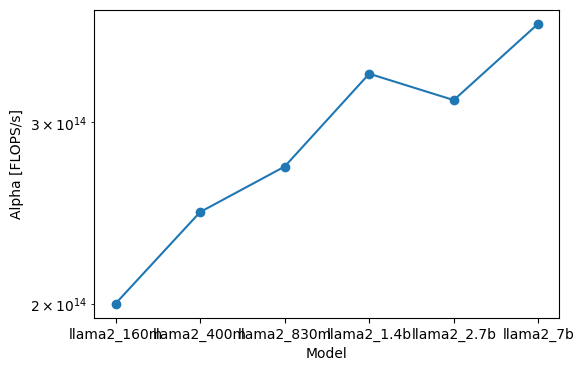

In [24]:
plt.figure(figsize=(6,4))
plt.plot(*zip(*alphas), marker="o")
plt.yscale("log")
plt.xlabel("Model")
plt.ylabel("Alpha [FLOPS/s]")

In [25]:
for m, a in alphas:
    print(m, a)

llama2_160m 200141552250592.44
llama2_400m 245574993758233.78
llama2_830m 271859606167469.84
llama2_1.4b 334525885874112.25
llama2_2.7b 315384959895383.4
llama2_7b 374211122448396.7
